# Toxic_Comment_Group_2_Presentation
Date of submission: 2023/12/06
## Research question: *Can we use pre-trained models to detect toxic comments?*
## Contributers
- Nguyen Mai Linh (Sandy) 20229031 
- Farhan Toshi Hermawan 20229531 
- Fariha Qorinatuz Zahra 21229529

## Executive Summary
DistilBERT-base-uncased is a model famous for sentiment analysis. We want to train it and see if the model can detect toxic comments. 
Dataset:
- 1000 youtube comment on Ferguson arrest from Kaggle https://www.kaggle.com/datasets/reihanenamdari/youtube-toxicity-data/data
- Label toxicity, obscenity, sexist, homophobic, and so on
- Taking comment and toxicity lable as our dataset
- Has almost 50/50 percentage of both toxic and non-toxic comments
- The video involved government and police aspects, which might impact the training of the model

### Conclusion:
- The model can detect toxicity in text with accuracy around 80%.
- Might not accurately predict data outside the dataset, as overfitting occured (higher validation loss than training loss).
- There is limitation due to context dependency, language development and subjectivity. 
- To improve, use larger dataset, add more parameters, and use a better hardware.
### Future work:
- A multi-label classification to further specify the comments. eg. threat, insult, hatecrime.
- Evaluate by checking unintended bias in the model by using ROC and F1 score.
- When tested with our own comments; we found that those that contains slightly negative words are marked as toxic, so it cannot do a more complex concept like sarcasm.


## 1. Download and import libraries

In [1]:
!pip install datasets

In [2]:
!pip install transformers==4.17

In [3]:
!pip install emoji

In [4]:
!pip install transformers[torch]

In [5]:
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

## 2. Data Preprocessing

### 2.1. Load the datasets and cleaning

In [6]:
df = pd.read_csv(r"youtoxic_english_1000.csv")
df.head()

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False,False,False,False,False
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False


In [7]:
df_toxic= df[["Text","IsToxic"]]
df_toxic.rename(
    columns={"Text": "text", "IsToxic": "label"},
    inplace=True,
)

df_toxic

C:\Users\LEGION\AppData\Local\Temp\ipykernel_16108\604080935.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_toxic.rename(


,text,label
0,If only people would just take a step back and...,False
1,Law enforcement is not trained to shoot to app...,True
2,\nDont you reckon them 'black lives matter' ba...,True
3,There are a very large number of people who do...,False
4,"The Arab dude is absolutely right, he should h...",False
...,...,...
995,I remember that they sent in the national defe...,False
996,Stats don`t represent the problem. Race baitin...,True
997,The quote from the mother... Wow that hit hard...,False
998,this video is so racist,False


In [8]:
df_toxic['category'] = df_toxic['label'].apply(lambda x: 'Toxic' if x == True else 'NonToxic')
df_toxic

C:\Users\LEGION\AppData\Local\Temp\ipykernel_16108\2396176749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_toxic['category'] = df_toxic['label'].apply(lambda x: 'Toxic' if x == True else 'NonToxic')


,text,label,category
0,If only people would just take a step back and...,False,NonToxic
1,Law enforcement is not trained to shoot to app...,True,Toxic
2,\nDont you reckon them 'black lives matter' ba...,True,Toxic
3,There are a very large number of people who do...,False,NonToxic
4,"The Arab dude is absolutely right, he should h...",False,NonToxic
...,...,...,...
995,I remember that they sent in the national defe...,False,NonToxic
996,Stats don`t represent the problem. Race baitin...,True,Toxic
997,The quote from the mother... Wow that hit hard...,False,NonToxic
998,this video is so racist,False,NonToxic


### 2.2. Changing the label to integer for model compatibility

In [9]:
df_toxic['label']=df_toxic['label'].astype(int)
df_toxic

C:\Users\LEGION\AppData\Local\Temp\ipykernel_16108\3885373790.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_toxic['label']=df_toxic['label'].astype(int)


,text,label,category
0,If only people would just take a step back and...,0,NonToxic
1,Law enforcement is not trained to shoot to app...,1,Toxic
2,\nDont you reckon them 'black lives matter' ba...,1,Toxic
3,There are a very large number of people who do...,0,NonToxic
4,"The Arab dude is absolutely right, he should h...",0,NonToxic
...,...,...,...
995,I remember that they sent in the national defe...,0,NonToxic
996,Stats don`t represent the problem. Race baitin...,1,Toxic
997,The quote from the mother... Wow that hit hard...,0,NonToxic
998,this video is so racist,0,NonToxic


In [11]:
df_toxic = df_toxic.drop(['category'], axis = 1)
df_toxic

,text,label
0,If only people would just take a step back and...,0
1,Law enforcement is not trained to shoot to app...,1
2,\nDont you reckon them 'black lives matter' ba...,1
3,There are a very large number of people who do...,0
4,"The Arab dude is absolutely right, he should h...",0
...,...,...
995,I remember that they sent in the national defe...,0
996,Stats don`t represent the problem. Race baitin...,1
997,The quote from the mother... Wow that hit hard...,0
998,this video is so racist,0


### 2.3. Replace emojis with text

In [12]:
# replace emoji with their shortcodes
comments = df_toxic['text']
import re
# For filtering comments with just emojis
import emoji

comments_emoji = []
preprocessed_text =[]
for comment_text in comments:
    for character in comment_text:
        if emoji.is_emoji(character):
            comments_emoji.append(character)
print(comments_emoji)

['👍', '💀', '💀', '😡', '🙄', '🙄', '🤦', '♂', '😔', '🤔', '🤔', '😂', '😭']


In [13]:
for comment_text in comments:
	replace_emoji=emoji.demojize(comment_text)
	preprocessed_text.append(replace_emoji)
preprocessed_text

["If only people would just take a step back and not make this case about them, because it wasn't about anyone except the two people in that situation.\xa0 To lump yourself into this mess and take matters into your own hands makes these kinds of protests selfish and without rational thought and investigation.\xa0 The guy in this video is heavily emotional and hyped up and wants to be heard, and when he gets heard he just presses more and more.\xa0 He was never out to have a reasonable discussion.\xa0 Kudos to the Smerconish for keeping level the whole time and letting Masri make himself out to be a fool.\xa0 How dare he and those that tore that city down in protest make this about themselves and to dishonor the entire incident with their own hate.\xa0 By the way, since when did police brutality become an epidemic?\xa0 I wish everyone would just stop pretending like they were there and they knew EXACTLY what was going on, because there's no measurable amount of people that honestly witn

In [14]:
df_toxic['text'] = preprocessed_text
df_toxic

,text,label
0,If only people would just take a step back and...,0
1,Law enforcement is not trained to shoot to app...,1
2,\nDont you reckon them 'black lives matter' ba...,1
3,There are a very large number of people who do...,0
4,"The Arab dude is absolutely right, he should h...",0
...,...,...
995,I remember that they sent in the national defe...,0
996,Stats don`t represent the problem. Race baitin...,1
997,The quote from the mother... Wow that hit hard...,0
998,this video is so racist,0


### 2.4 Visualization of the data

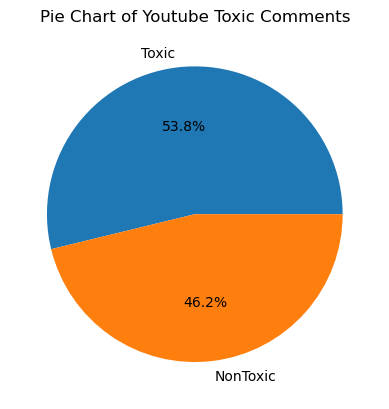

In [37]:
df_extra = df_toxic.copy()
df_extra['category'] = df_extra['label'].apply(lambda x: 'Toxic' if x == 1 else 'NonToxic')
import matplotlib.pyplot as plt
# Create a pie chart
plt.pie(df_extra['category'].value_counts(), labels=['Toxic', 'NonToxic'], autopct='%1.1f%%')
plt.title('Pie Chart of Youtube Toxic Comments')
plt.show()

In [16]:
dataset = Dataset.from_pandas(df_toxic)

In [17]:
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

## 2.5. Splitting train and test data

In [18]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

In [19]:
train_dataset = Dataset.from_dict(train_dataset)

In [20]:
test_dataset = Dataset.from_dict(test_dataset)

## 3. Model

In [21]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline

# model_path = "martin-ha/toxic-comment-model"
model_path = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_clas

In [22]:
# Tokenize your dataset
def tokenize_batch(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)

tokenized_train = train_dataset.map(tokenize_batch, batched=True)
tokenized_test = test_dataset.map(tokenize_batch, batched=True)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [23]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Define the evaluation metrics
# import numpy as np
# from datasets import load_metric

# def compute_metrics(eval_pred):
#     load_accuracy = load_metric("accuracy")
#     load_f1 = load_metric("f1")

#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
#     f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
#     return {"accuracy": accuracy, "f1": f1}

In [34]:
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Compute accuracy and F1 score
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]

    # Add computation for training loss and validation loss
    # Assuming that logits and labels are torch.Tensor or numpy arrays
    loss = compute_loss(logits, labels)

    return {"accuracy": accuracy, "f1": f1, "loss": loss}

def compute_loss(logits, labels):
    # Your custom loss computation logic here
    # This might involve using a loss function like CrossEntropyLoss
    # Make sure to adjust this based on your specific setup
    # Example using PyTorch CrossEntropyLoss:
    import torch
    criterion = torch.nn.CrossEntropyLoss()
    logits_tensor = torch.from_numpy(logits)
    labels_tensor = torch.from_numpy(labels)
    loss = criterion(logits_tensor, labels_tensor)
    return loss.item()

In [35]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="trainer_test", evaluation_strategy="epoch", num_train_epochs = 7, logging_steps = 100)
# training_args = TrainingArguments(
#     output_dir=output_dir,
#     learning_rate=2e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     num_train_epochs=2,
#     weight_decay=0.01,
#     save_strategy="epoch",
#     push_to_hub=False,
# )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [36]:
# Train the model
trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
C:\Users\LEGION\anaconda3\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 800
  Num Epochs = 7
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 700


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.324000,0.743994,0.730000,0.678571
2,0.200300,0.856632,0.780000,0.800000
3,0.057400,1.026870,0.810000,0.813725
4,0.010800,1.388765,0.795000,0.787565
5,0.009100,1.394633,0.775000,0.773869
6,0.000300,1.450477,0.780000,0.777778
7,0.000300,1.466558,0.780000,0.777778


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 8
C:\Users\LEGION\AppData\Local\Temp\ipykernel_16108\628896212.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 8
The followin

TrainOutput(global_step=700, training_loss=0.08604398264150534, metrics={'train_runtime': 6703.5116, 'train_samples_per_second': 0.835, 'train_steps_per_second': 0.104, 'total_flos': 705595878153600.0, 'train_loss': 0.08604398264150534, 'epoch': 7.0})

In [38]:
trainer.save_model(r"C:\Users\LEGION\Desktop\pds\model")

Saving model checkpoint to C:\Users\LEGION\Desktop\pds\model
Configuration saved in C:\Users\LEGION\Desktop\pds\model\config.json
Model weights saved in C:\Users\LEGION\Desktop\pds\model\pytorch_model.bin
tokenizer config file saved in C:\Users\LEGION\Desktop\pds\model\tokenizer_config.json
Special tokens file saved in C:\Users\LEGION\Desktop\pds\model\special_tokens_map.json


## 4. Results and evaluation

In [39]:
training_history = trainer.state.log_history

In [40]:
training_history

[{'loss': 0.324,
  'learning_rate': 4.2857142857142856e-05,
  'epoch': 1.0,
  'step': 100},
 {'eval_loss': 0.7439936995506287,
  'eval_accuracy': 0.73,
  'eval_f1': 0.6785714285714285,
  'eval_runtime': 78.743,
  'eval_samples_per_second': 2.54,
  'eval_steps_per_second': 0.317,
  'epoch': 1.0,
  'step': 100},
 {'loss': 0.2003,
  'learning_rate': 3.571428571428572e-05,
  'epoch': 2.0,
  'step': 200},
 {'eval_loss': 0.8566317558288574,
  'eval_accuracy': 0.78,
  'eval_f1': 0.7999999999999999,
  'eval_runtime': 79.4168,
  'eval_samples_per_second': 2.518,
  'eval_steps_per_second': 0.315,
  'epoch': 2.0,
  'step': 200},
 {'loss': 0.0574,
  'learning_rate': 2.857142857142857e-05,
  'epoch': 3.0,
  'step': 300},
 {'eval_loss': 1.026869535446167,
  'eval_accuracy': 0.81,
  'eval_f1': 0.8137254901960783,
  'eval_runtime': 109.1661,
  'eval_samples_per_second': 1.832,
  'eval_steps_per_second': 0.229,
  'epoch': 3.0,
  'step': 300},
 {'loss': 0.0108,
  'learning_rate': 2.1428571428571428e-05,

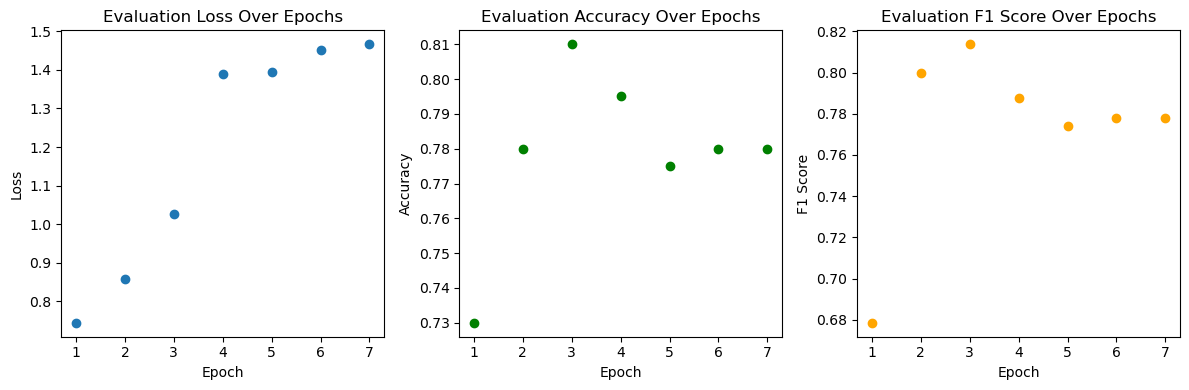

In [44]:
epochs = [entry['epoch'] for entry in training_history]
eval_loss = [entry.get('eval_loss', None) for entry in training_history]
eval_accuracy = [entry.get('eval_accuracy', None) for entry in training_history]
eval_f1 = [entry.get('eval_f1', None) for entry in training_history]

# Plotting loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(epochs, eval_loss, marker='o')
plt.title('Evaluation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plotting accuracy
plt.subplot(1, 3, 2)
plt.scatter(epochs, eval_accuracy, marker='o', color='green')
plt.title('Evaluation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plotting F1 score
plt.subplot(1, 3, 3)
plt.scatter(epochs, eval_f1, marker='o', color='orange')
plt.title('Evaluation F1 Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

In [48]:
training_history_handInput = {
    'Epoch': [1, 2, 3, 4, 5, 6, 7],
    'Training Loss': [0.324, 0.2003, 0.0574, 0.0108, 0.0091, 0.0003, 0.0003],
    'Validation Loss': [0.743994, 0.856632, 1.02687, 1.388765, 1.394633, 1.450477, 1.466558],
    'Accuracy': [0.73, 0.78, 0.81, 0.795, 0.775, 0.78, 0.78],
    'F1': [0.678571, 0.8, 0.813725, 0.787565, 0.773869, 0.777778, 0.777778]
}

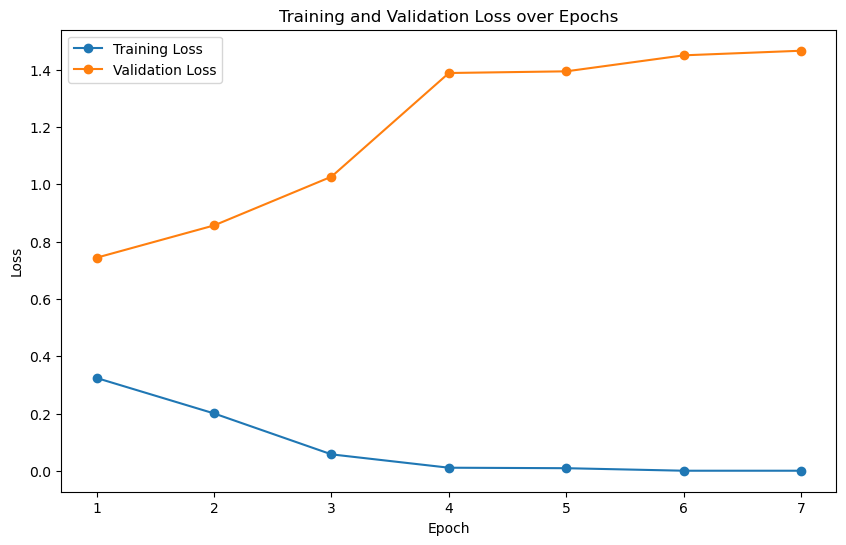

In [50]:
df_training_history = pd.DataFrame(training_history_handInput)

# Plotting
plt.figure(figsize=(10, 6))

# Training and Validation Loss
plt.plot(df_training_history['Epoch'], df_training_history['Training Loss'], label='Training Loss', marker='o')
plt.plot(df_training_history['Epoch'], df_training_history['Validation Loss'], label='Validation Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 200
  Batch size = 8


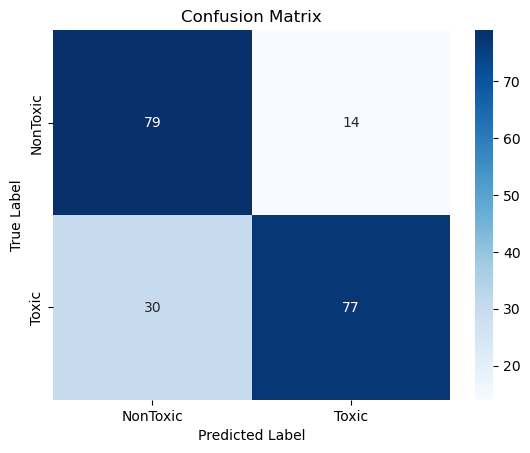

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'label' is a column in your test dataset
y_true = test_dataset['label']

# Get predictions from the model
predictions = trainer.predict(tokenized_test)
y_pred = predictions.predictions.argmax(axis=1)

# Define the class names
class_names = ['NonToxic', 'Toxic']

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with class names
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Set the x-axis and y-axis labels
plt.xticks(ticks=[0.5, 1.5], labels=['NonToxic', 'Toxic'])
plt.yticks(ticks=[0.5, 1.5], labels=['NonToxic', 'Toxic'])

plt.show()


## 5. Try the new model

In [54]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

model_path = "C:\\Users\\LEGION\\Desktop\\pds\\model"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Create a sentiment analysis pipeline using your local model
toxic_model = pipeline(task="sentiment-analysis", model=model, tokenizer=tokenizer)

Didn't find file C:\Users\LEGION\Desktop\pds\model\added_tokens.json. We won't load it.
loading file C:\Users\LEGION\Desktop\pds\model\vocab.txt
loading file C:\Users\LEGION\Desktop\pds\model\tokenizer.json
loading file None
loading file C:\Users\LEGION\Desktop\pds\model\special_tokens_map.json
loading file C:\Users\LEGION\Desktop\pds\model\tokenizer_config.json
loading configuration file C:\Users\LEGION\Desktop\pds\model\config.json
Model config DistilBertConfig {
  "_name_or_path": "C:\\Users\\LEGION\\Desktop\\pds\\model",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights

In [86]:
test_comments = [
    "This is so f*cking stupid!",
    "Humankind is crazy.",
    "All hope is lost",
    "We're are going to die",
    "We all deserve peace",
    "You should get",
    "I am amazed by your stupidity",
    "This is fucking good",
    "I like you"
]
result = []
for comment in test_comments:
    run = toxic_model(comment)
    result.append(comment)
    result.append(run)


In [87]:
result

['This is so f*cking stupid!',
 [{'label': 'LABEL_1', 'score': 0.9997954964637756}],
 'Humankind is crazy.',
 [{'label': 'LABEL_1', 'score': 0.9996520280838013}],
 'All hope is lost',
 [{'label': 'LABEL_0', 'score': 0.9977966547012329}],
 "We're are going to die",
 [{'label': 'LABEL_1', 'score': 0.9992921352386475}],
 'We all deserve peace',
 [{'label': 'LABEL_0', 'score': 0.9977565407752991}],
 'You should get',
 [{'label': 'LABEL_1', 'score': 0.9947368502616882}],
 'I am amazed by your stupidity',
 [{'label': 'LABEL_1', 'score': 0.9989134073257446}],
 'This is fucking good',
 [{'label': 'LABEL_1', 'score': 0.9990739822387695}],
 'I like you',
 [{'label': 'LABEL_0', 'score': 0.9998189806938171}]]

## The end

*your toxic im slipping under :D*
https://www.youtube.com/watch?v=LOZuxwVk7TU